In [1]:
%env THEANO_FLAGS='device=cuda', 'floatX=float32', 'gpuarray.preallocate=0.2'

env: THEANO_FLAGS='device=cuda', 'floatX=float32', 'gpuarray.preallocate=0.2'


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import theano
import theano.tensor as T

from craynn.utils import mnist

from tqdm import tqdm_notebook

Using cuDNN version 7005 on context None
Preallocating 1622/8110 Mb (0.200000) on cuda
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


## Data

In [3]:
X_train, _, X_test, _ = mnist(cast='float32')

In [4]:
X_train /= 255.0
X_test /= 255.0

In [5]:
alpha1 = 10
alpha2 = 25

angle_dist = lambda alpha: lambda shape: np.random.normal(alpha, 20, size=shape)
angle_dist1 = angle_dist(alpha1)
angle_dist2 = angle_dist(alpha2)

In [6]:
def get_rotated(X, repeat=4):
    indx = np.random.permutation(X.shape[0])
    n = X.shape[0]

    X_rot = X[indx[(n // 2):]]
    X_rot = np.repeat(X_rot, repeats=repeat, axis=0)
    
    X_original = X[indx[:(n // 2)]]
    X_original = np.repeat(X_original, repeats=repeat, axis=0)
    
    def rotate_data(X, angles):
        from skimage.transform import rotate

        if not hasattr(angles, 'shape'):
            angles = np.ones(X.shape[0]) * angles
        return np.array([
            rotate(X[i, 0], angle=angles[i], order=3, resize=False, preserve_range=True).reshape(1, 28, 28)
            for i in tqdm_notebook(range(X.shape[0]))
        ]).astype('float32')
    
    
    ### more artefacts!
    angles = angle_dist1(X_rot.shape[0])
    X_rot = rotate_data(X_rot, 2 * angles)
    X_rot = rotate_data(X_rot, -angles)

    angles = angle_dist2(X_original.shape[0])
    X_original = rotate_data(X_original, angles = 2 * angles)
    X_original = rotate_data(X_original, angles = -angles)
    
    X = np.vstack([X_original, X_rot])
    X += np.random.normal(0, 0.2, size=X.shape)

    y = np.hstack([
        np.ones(X_original.shape[0], dtype='float32'),
        np.zeros(X_rot.shape[0], dtype='float32')
    ])
    
    indx = np.random.permutation(X.shape[0])
    return X[indx], y[indx]

### Lower bound on cross-entropy

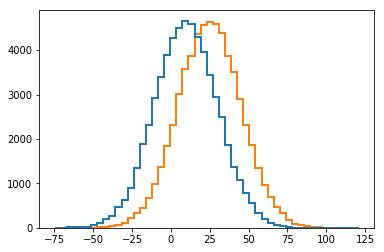

In [7]:
_ = plt.hist([
    angle_dist1(60000),
    angle_dist2(60000),
], bins=50, histtype='step', lw=2)

In [8]:
xs_ = T.fvector()

xs = xs_[:-1]
deltas = xs_[1:] - xs_[:-1]


a = T.fscalar()
b = T.fscalar()

sigma = T.fscalar()

n = -0.5 / (sigma ** 2)
Z = 1.0 / T.sqrt(2 * np.pi) / sigma

### note log1p instead of log
log_f = -T.log1p(T.exp(n * ( (xs - b) ** 2 - (xs - a) ** 2 )))
log_1_f = -T.log1p(T.exp(n * ( (xs - a) ** 2 - (xs - b) ** 2 )))

p = Z * T.exp(n * (xs - a) ** 2)
q = Z * T.exp(n * (xs - b) ** 2)

loss = -0.5 * T.sum(deltas * p * log_f) - 0.5 * T.sum(deltas * q * log_1_f)

In [11]:
loss.eval({
    xs_ : np.linspace(-120, 120, num=1000000, dtype='float32'),
    a : alpha1,
    b : alpha2,
    sigma : 20
})

array(0.6273792, dtype=float32)

*let's continue...*

In [ ]:
X_train, y_train = get_rotated(X_train)
X_test, y_test = get_rotated(X_test)

HBox(children=(IntProgress(value=0, max=120000), HTML(value='')))

In [ ]:
plt.subplots(nrows=2, ncols=10, figsize=(30, 6))

for j in range(10):
    plt.subplot(2, 10, j + 1)
    plt.imshow(X_train[2 * j, 0], cmap=plt.cm.Greys_r)

    plt.subplot(2, 10, j + 10 + 1)
    plt.imshow(X_train[2 * j + 1, 0], cmap=plt.cm.Greys_r)

## Network

In [ ]:
from craynn.layers import *
from craynn.networks import *
from craynn.subnetworks import *
from craynn.updates import *
from craynn.utils import lsum
from craynn.viz import SNNWatcher, draw_to_notebook

In [ ]:
n = 8

nn = net((None, 1, 28, 28))(
    conv(n, f=T.nnet.softplus),
    conv(n, f=T.nnet.softplus),
    max_pool(),
    
    conv(int(1.5 * n), f=T.nnet.softplus),
    conv(int(1.5 * n), f=T.nnet.softplus),
    max_pool(),
    
    conv(2 * n, f=T.nnet.softplus),
    
    dense(1, f = lambda x: x),
    flatten(outdim=1)
)

In [ ]:
draw_to_notebook(nn)

In [ ]:
print(nn.description())

In [ ]:
X = T.ftensor4()
y = T.fvector()

In [ ]:
f, = nn(X)

In [ ]:
nn.reg_l2().eval()

In [ ]:
losses = y * T.nnet.softplus(-f) + (1 - y) * T.nnet.softplus(f)

C_reg = T.fscalar()

pure_loss = T.mean(losses)
regularization = nn.reg_l2()
loss = pure_loss + C_reg * T.exp(regularization)

In [ ]:
learning_rate = T.fscalar()

upd = rmsprop(loss, nn.params(), learning_rate=learning_rate)

train = theano.function(
    [X, y, learning_rate, C_reg],
    [pure_loss, regularization],
    updates=upd, allow_input_downcast=True
)

In [ ]:
predict = theano.function([X], T.nnet.sigmoid(f))

In [ ]:
get_loss = theano.function([X, y], T.sum(losses))

In [ ]:
watcher = SNNWatcher(
    title='mnist cnn', mode='fill',
    labels=('train loss', 'test loss'),
    colors=('blue', 'green')
)

num_epoches = 16
num_batches = X_train.shape[0] // 32

losses = np.ndarray(shape=(num_epoches, num_batches), dtype='float32')
test_losses = np.ndarray(shape=(num_epoches, 1), dtype='float32')
regs = np.ndarray(shape=(num_epoches, num_batches), dtype='float32')

stream = streams.inf_random(X_train.shape[0], batch_size=32)

for i in range(num_epoches):
    for j in range(num_batches):
        indx = next(stream)
        losses[i, j], regs[i, j] = train(X_train[indx], y_train[indx], 1.0e-3, 1.0e-4)

    test_losses[i, 0] = np.sum([
        get_loss(X_test[indx], y_test[indx])
        for indx in streams.seq(X_test.shape[0], batch_size=128)
    ]) / X_test.shape[0]

    watcher.draw(
        losses[:(i + 1)],
        test_losses[:(i + 1)]
    )

In [ ]:
np.sum([
    np.sum((predict(X_test[indx]) > 0.5) == y_test[indx])
    for indx in streams.seq(X_test.shape[0], batch_size=128)
]) / X_test.shape[0]

In [ ]:
np.sum([
    np.sum((predict(X_train[indx]) > 0.5) == y_train[indx])
    for indx in streams.seq(X_train.shape[0], batch_size=128)
]) / X_train.shape[0]